Question 01

6.10347256892574
9.870626312582996


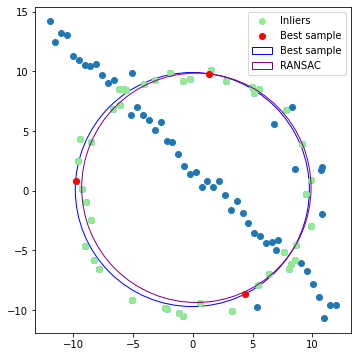

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import linalg

def ShortestDistance(p,centerx,centery,radius):
    d= np.array(abs(((p[:,0]-centerx)**2+(p[:,1]-centery)**2)**0.5-radius))
    return d

def Circlefinder(pt1, pt2, pt3):
    temp = pt2[0]**2 + pt2[1]**2
    bc = (pt1[0]**2 + pt1[1]**2 - temp)/2
    cd = (temp - pt3[0]**2 - pt3[1]**2)/2
    det = (pt1[0] - pt2[0]) * (pt2[1] - pt3[1]) - (pt2[0] - pt3[0]) * (pt1[1] - pt2[1])
    if abs(det) < 1.0e-10:
        return None
    c_x = (bc*(pt2[1] - pt3[1]) - cd*(pt1[1] - pt2[1]))/ det
    c_y = ((pt1[0] - pt2[0]) * cd - (pt2[0] - pt3[0])*bc)/ det
    r = ((c_x - pt1[0])**2 + (c_y - pt1[1])**2)**0.5

    return c_x, c_y, r

def CirclePlotting(Data,Datalist,color='y'):
    cen_x, cen_y, radius = Circlefinder(Datalist[Data[0]],Datalist[Data[1]],Datalist[Data[2]])
    c = plt.Circle((cen_x, cen_y), radius, fill=False)
    c.set_color(color)
    return c

def RANSAC(Data,iteration,thresh,NoOfInlier):
    maximum = 0
    output = np.array([])
    for i in range(iteration):
        randomPoints = np.random.choice(Data.size//2, size=3, replace=False)
        cen_x, cen_y, radius = Circlefinder(Data[randomPoints[0]],Data[randomPoints[1]],Data[randomPoints[2]])
        PO = ShortestDistance(Data, cen_x, cen_y, radius)

        if radius > max(Data[:,1])*1.5:
            continue
        inliers = Data[PO < thresh]

        if len(inliers) > NoOfInlier:
               
            shrt_d = ShortestDistance (inliers,cen_x,cen_y,radius)
            mean = sum(shrt_d/shrt_d.size)
            if maximum < len(inliers):
                best = mean
                output = randomPoints
                inli = inliers
            elif maximum == len(inliers) and best > mean:
                best = mean
                output = randomPoints
                inli = inliers
    print(radius)
    return output,inli

# np . random. seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np.linspace (-12, 12 , half_n )
y = m*x + b + s*np.random.randn(half_n)
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )

ranL, bestInlier = RANSAC(X,500,1,40)         
circ1 = CirclePlotting(ranL,X, color = 'blue')
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect(1)
ax.add_artist(circ1)
p1 = ax.scatter(X[:,0],X[:,1])
Inliers = ax.scatter(bestInlier[:,0],bestInlier[:,1], color='lightgreen' )
bestfit, inl = RANSAC(bestInlier,50,1,bestInlier.size//2.2)
circ2 = CirclePlotting(bestfit,bestInlier, color ='purple')
ax.add_artist( circ2 )
Y = np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
Bestsamples = ax.scatter(Y[:,0],Y[:,1], c = 'r')
plt.legend(handles=[Inliers,Bestsamples,circ1,circ2],labels=['Inliers','Best sample','Best sample','RANSAC'])
plt.show()


Question 02

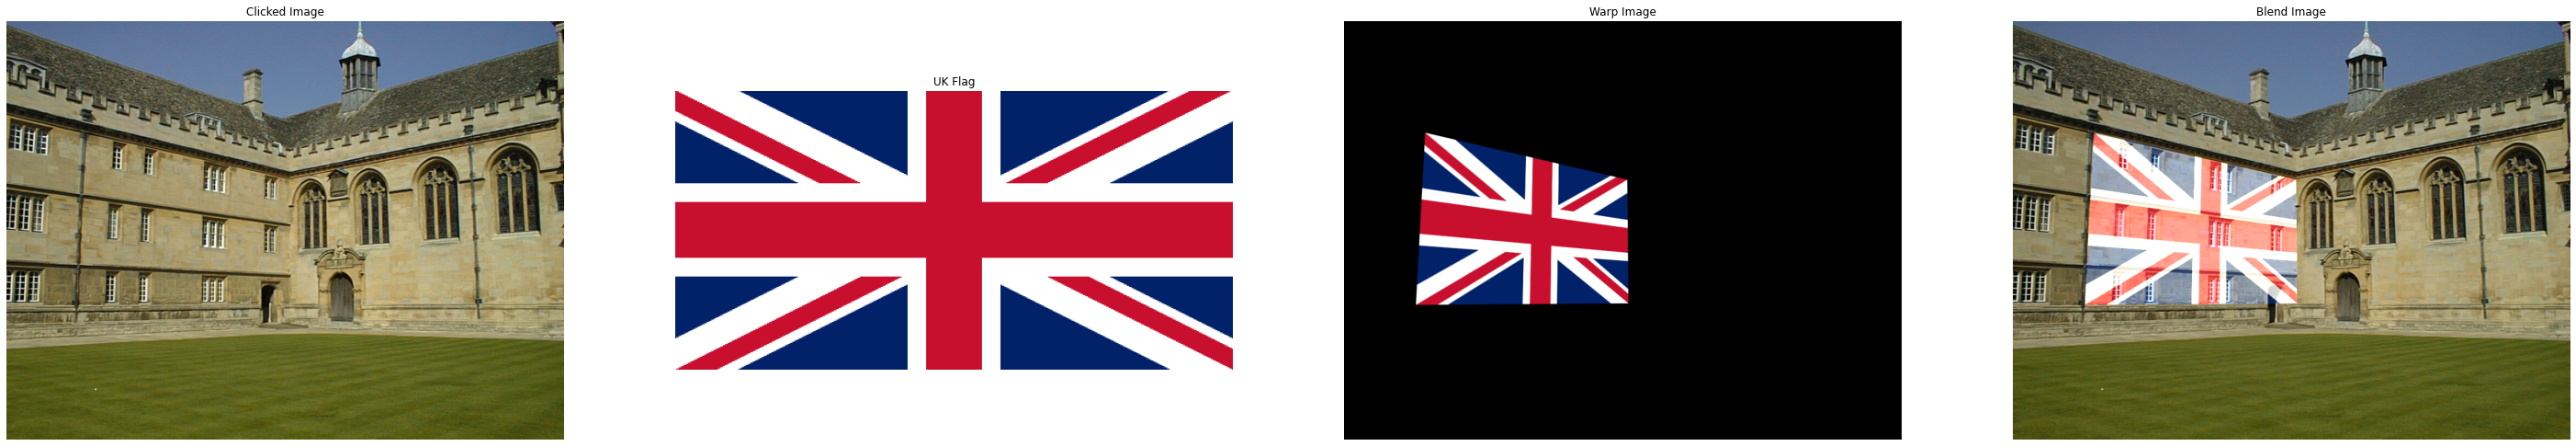

In [4]:
count = 0
points = []
width = 0
height = 0

arch_img1 = cv.imread(r'./assingment2_images/001.jpg', cv.IMREAD_COLOR)
arch_img2 = cv.imread(r'./assingment2_images/003.jpg', cv.IMREAD_COLOR)
imgflag = cv.imread(r'./assingment2_images/Flag_of_the_United_Kingdom.svg.png', cv.IMREAD_REDUCED_COLOR_4)
img1 = arch_img1
img2 = arch_img2
def mousePoints(event, x, y, flags, params):
    global count
    global points
    if count < 4:
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            count += 1
    return None
def getshape(pts):
    global width
    global height
    width = (abs(pts[0][0] - pts[1][0]) + abs(pts[2][0] - pts[3][0]))//2
    height = (abs(pts[0][1] - pts[2][1]) + abs(pts[1][1] - pts[3][1]))//2
    return width, height
cv.imshow("original image", arch_img1)
cv.setMouseCallback("original image", mousePoints)
cv.waitKey(0)
cv.destroyAllWindows() 

pts_src = np.array([[0,0], [imgflag.shape[1],0], [0, imgflag.shape[0]], [imgflag.shape[1],imgflag.shape[0]]]) 
pts_dst = np.array(points)
shape0, shape1 = getshape(points)

h , status = cv.findHomography(pts_src, pts_dst,cv.RANSAC, 5.0)
output_imge = cv.warpPerspective(imgflag, h, (arch_img1.shape[1], arch_img1.shape[0]))
blend_image = cv.addWeighted(arch_img1, 0.95, output_imge, 0.8, 0.0)

fig, ax = plt.subplots(1,4, figsize = (50,10))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB)), ax[0].set_title("Clicked Image"), ax[0].axis('off') 
ax[1].imshow(cv.cvtColor(imgflag, cv.COLOR_BGR2RGB)), ax[1].set_title("UK Flag"), ax[1].axis('off') 
ax[2].imshow(cv.cvtColor(output_imge, cv.COLOR_BGR2RGB)), ax[2].set_title("Warp Image"),ax[2].axis('off')
ax[3].imshow(cv.cvtColor(blend_image, cv.COLOR_BGR2RGB)), ax[3].set_title("Blend Image"), ax[3].axis('off')
plt.show()

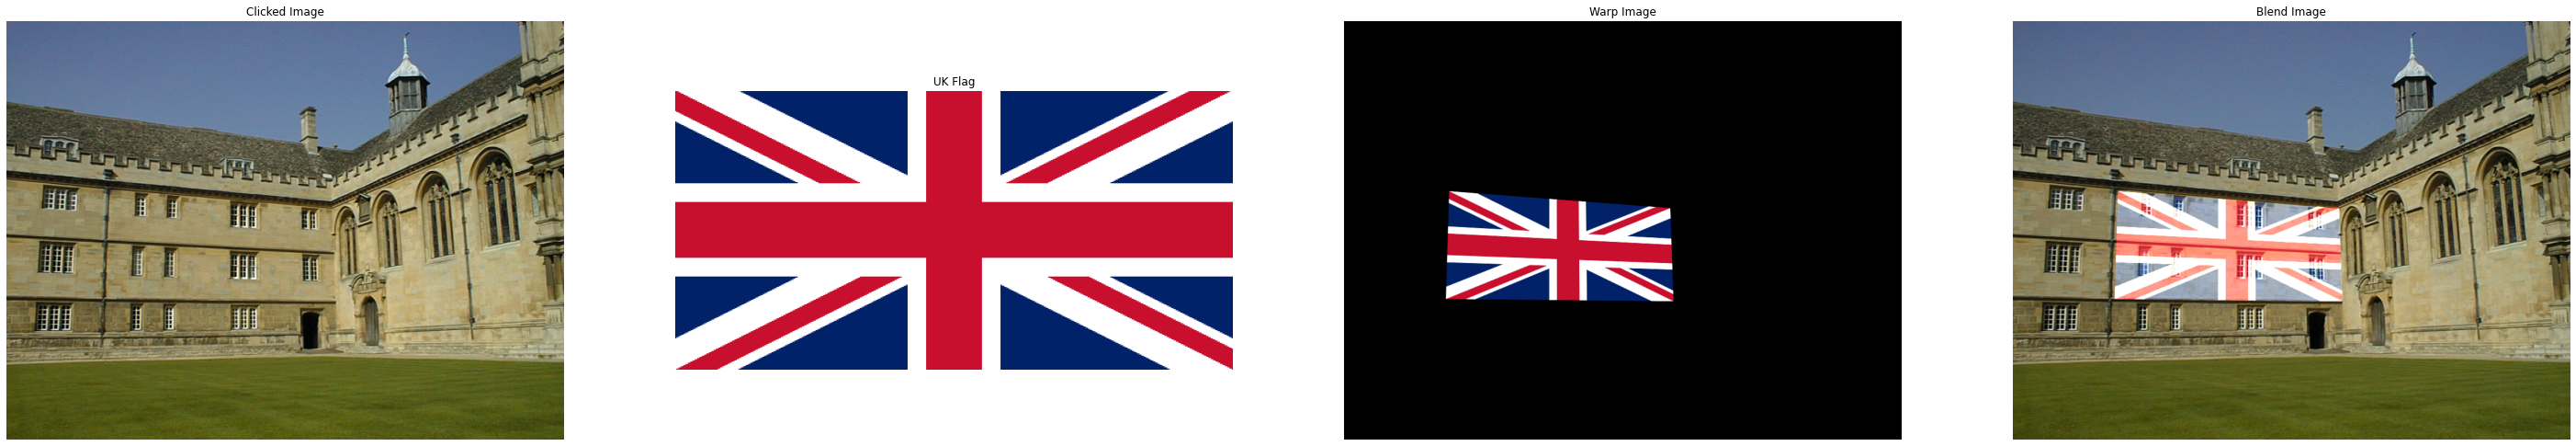

In [5]:
count = 0
points = []
width = 0
height = 0

arch_img1 = cv.imread(r'./assingment2_images/001.jpg', cv.IMREAD_COLOR)
arch_img2 = cv.imread(r'./assingment2_images/003.jpg', cv.IMREAD_COLOR)
imgflag = cv.imread(r'./assingment2_images/Flag_of_the_United_Kingdom.svg.png', cv.IMREAD_REDUCED_COLOR_4)
img1 = arch_img1
img2 = arch_img2
def mousePoints(event, x, y, flags, params):
    global count
    global points
    if count < 4:
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            count += 1
    return None
def getshape(pts):
    global width
    global height
    width = (abs(pts[0][0] - pts[1][0]) + abs(pts[2][0] - pts[3][0]))//2
    height = (abs(pts[0][1] - pts[2][1]) + abs(pts[1][1] - pts[3][1]))//2
    return width, height
cv.imshow("original image", arch_img2)
cv.setMouseCallback("original image", mousePoints)
cv.waitKey(0)
cv.destroyAllWindows() 

pts_src = np.array([[0,0], [imgflag.shape[1],0], [0, imgflag.shape[0]], [imgflag.shape[1],imgflag.shape[0]]]) 
pts_dst = np.array(points)
shape0, shape1 = getshape(points) 

h , status = cv.findHomography(pts_src, pts_dst,cv.RANSAC, 5.0)
output_imge = cv.warpPerspective(imgflag, h, (arch_img2.shape[1], arch_img2.shape[0]))
blend_image = cv.addWeighted(arch_img2, 0.95, output_imge, 0.8, 0.0)

fig, ax = plt.subplots(1,4, figsize = (50,10))
ax[0].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB)), ax[0].set_title("Clicked Image"), ax[0].axis('off') 
ax[1].imshow(cv.cvtColor(imgflag, cv.COLOR_BGR2RGB)), ax[1].set_title("UK Flag"), ax[1].axis('off') 
ax[2].imshow(cv.cvtColor(output_imge, cv.COLOR_BGR2RGB)), ax[2].set_title("Warp Image"),ax[2].axis('off')
ax[3].imshow(cv.cvtColor(blend_image, cv.COLOR_BGR2RGB)), ax[3].set_title("Blend Image"), ax[3].axis('off')
plt.show()

Question 03

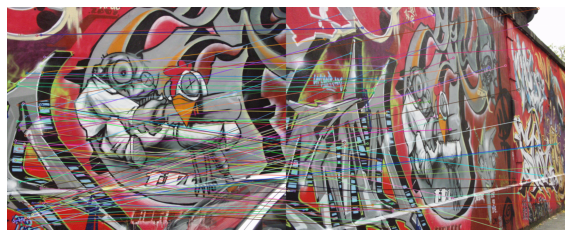

((<DMatch 000001AA85C61A30>,
  <DMatch 000001AA86568F90>,
  <DMatch 000001AA88560C30>,
  <DMatch 000001AA88560210>,
  <DMatch 000001AA88560410>,
  <DMatch 000001AA88560CD0>,
  <DMatch 000001AA88560E30>,
  <DMatch 000001AA88560E70>,
  <DMatch 000001AA88560850>,
  <DMatch 000001AA88560BF0>,
  <DMatch 000001AA88560310>,
  <DMatch 000001AA88560470>,
  <DMatch 000001AA88560570>,
  <DMatch 000001AA88543B10>,
  <DMatch 000001AA88543A90>,
  <DMatch 000001AA88543990>,
  <DMatch 000001AA88543CD0>,
  <DMatch 000001AA88543830>,
  <DMatch 000001AA88543950>,
  <DMatch 000001AA8856ED90>,
  <DMatch 000001AA8858DE30>,
  <DMatch 000001AA8858D690>,
  <DMatch 000001AA8858D5F0>,
  <DMatch 000001AA8858DD30>,
  <DMatch 000001AA8858DCF0>,
  <DMatch 000001AA8858DF30>,
  <DMatch 000001AA88589E70>,
  <DMatch 000001AA88589D30>,
  <DMatch 000001AA88589CD0>,
  <DMatch 000001AA885899B0>,
  <DMatch 000001AA88589F30>,
  <DMatch 000001AA88589CF0>,
  <DMatch 000001AA88589C90>,
  <DMatch 000001AA88589D10>,
  <DMatch 0000

In [8]:
# read images
img1 = cv.imread(r'./assingment2_images/img1.ppm',cv.IMREAD_COLOR)
img2 = cv.imread(r'./assingment2_images/img2.ppm',cv.IMREAD_COLOR)
img3 = cv.imread(r'./assingment2_images/img3.ppm',cv.IMREAD_COLOR)
img4 = cv.imread(r'./assingment2_images/img4.ppm',cv.IMREAD_COLOR)  
img5 = cv.imread(r'./assingment2_images/img5.ppm',cv.IMREAD_COLOR) 
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
img4 = cv.cvtColor(img4, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

def SIFT(img1,img2):
    sift = cv.SIFT_create(nfeatures=0,nOctaveLayers=3,contrastThreshold=0.04,edgeThreshold=10,sigma=1.6) #sift
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)    #feature matching
    matches = bf.match(descriptors_1,descriptors_2)
    sortmatches = sorted(matches, key = lambda x:x.distance)
    img3 = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:100], img2, flags=2)
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.imshow(img3)
    ax.axis('off')
    plt.show()
    return matches,[keypoints_1,keypoints_2]
SIFT(img1,img5)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import random


def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h


def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        
        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers


correspondenceList1 = []
correspondenceList2 = []
keypoints1 = [kp1,kp2]
keypoints2 = [kp2,kp3]

for match in matches1:
    (x1, y1) = keypoints1[0][match.queryIdx].pt
    (x2, y2) = keypoints1[1][match.trainIdx].pt
    correspondenceList1.append([x1, y1, x2, y2])

for match in matches2:
    (x3, y3) = keypoints2[0][match.queryIdx].pt
    (x4, y4) = keypoints2[1][match.trainIdx].pt
    correspondenceList2.append([x3, y3, x4, y4])

corrs1 = np.matrix(correspondenceList1)
corrs2 = np.matrix(correspondenceList2)

finalH1, inliers1 = ransac(corrs1, 0.6)
finalH2, inliers2 = ransac(corrs2, 0.6)

finalH = np.matmul(finalH2, finalH1)

print(finalH)

NameError: name 'kp1' is not defined